In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sbihack/HACKATHON_PREDICTION_DATA.CSV
/kaggle/input/sbihack/HACKATHON_TRAINING_DATA.CSV


In [2]:
df = pd.read_csv('/kaggle/input/sbihack/HACKATHON_TRAINING_DATA.CSV')

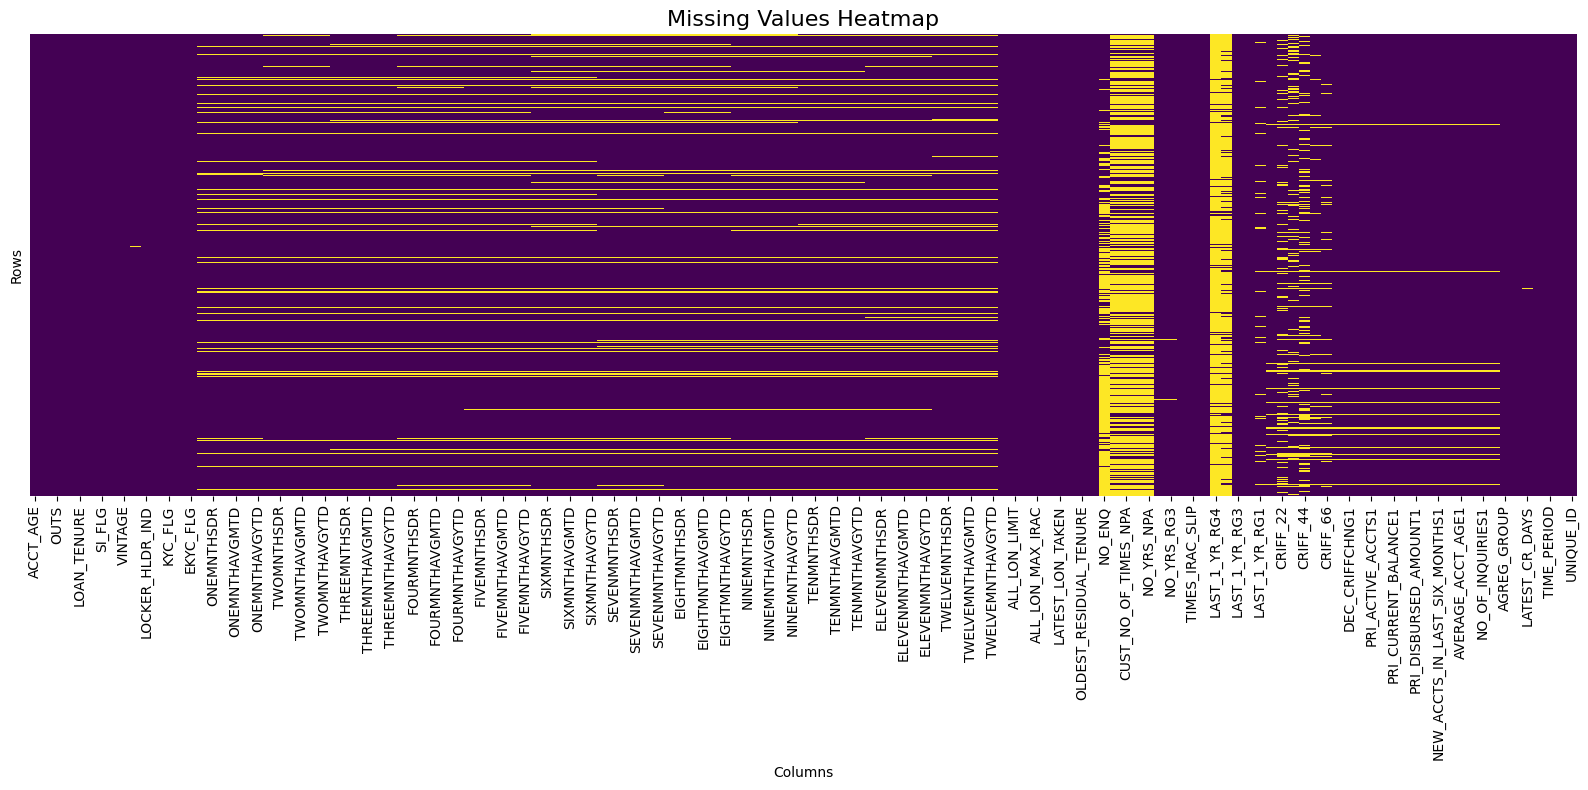

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the figure size
plt.figure(figsize=(16, 8))

# Plot the heatmap
sns.heatmap(df.isnull(), 
            cbar=False, 
            cmap='viridis', 
            yticklabels=False)

plt.title('Missing Values Heatmap', fontsize=16)
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.tight_layout()
plt.show()

In [4]:
df.dtypes

ACCT_AGE                float64
LIMIT                   float64
OUTS                    float64
ACCT_RESIDUAL_TENURE    float64
LOAN_TENURE               int64
                         ...   
LATEST_CR_DAYS          float64
LATEST_DR_DAYS            int64
TIME_PERIOD              object
TARGET                    int64
UNIQUE_ID                 int64
Length: 139, dtype: object

In [5]:
df.shape

(327741, 139)

In [6]:
import pandas as pd
import numpy as np
from collections import Counter
from tqdm import tqdm

# Enable tqdm for pandas apply
tqdm.pandas()

# Set thresholds
low_thresh = 0.005
mid_thresh = 0.10

# Separate numerical and categorical columns
numerical_cols = df.select_dtypes(include=[np.number]).columns
categorical_cols = df.select_dtypes(exclude=[np.number]).columns

# 1. DROP rows where missing values are in columns with < 0.5% missing
print("Step 1: Dropping rows with missing values in columns with <0.5% missing...")
missing_percent = df.isnull().mean()
cols_to_drop_rows = missing_percent[missing_percent < low_thresh].index

if not cols_to_drop_rows.empty:
    print(f"Dropping rows for columns: {list(cols_to_drop_rows)}")
    df = df.dropna(subset=cols_to_drop_rows)

# 2. Mean ± Std Imputation for Numerical Columns with 0.5% to 10% missing
print("\nStep 2: Mean ± Std Imputation for numerical columns with 0.5–10% missing...")
impute_cols = missing_percent[(missing_percent >= low_thresh) & (missing_percent <= mid_thresh)]
impute_numerical = [col for col in impute_cols.index if col in numerical_cols]

for col in tqdm(impute_numerical, desc="Imputing numerical columns"):
    mean = df[col].mean()
    std = df[col].std()
    mask = df[col].isnull()
    imputed_values = np.random.normal(loc=mean, scale=std, size=mask.sum())
    df.loc[mask, col] = imputed_values

# 3. Random Sampling Imputation for Categorical Columns with 0.5% to 10% missing
print("\nStep 3: Random sampling for categorical columns with 0.5–10% missing...")
impute_categorical = [col for col in impute_cols.index if col in categorical_cols]

for col in tqdm(impute_categorical, desc="Imputing categorical columns"):
    non_null_values = df[col].dropna().values
    mask = df[col].isnull()
    imputed_values = np.random.choice(non_null_values, size=mask.sum(), replace=True)
    df.loc[mask, col] = imputed_values

print("\n✅ Imputation using mean ± std (numerical) and random sampling (categorical) complete.")


Step 1: Dropping rows with missing values in columns with <0.5% missing...
Dropping rows for columns: ['ACCT_AGE', 'LIMIT', 'OUTS', 'ACCT_RESIDUAL_TENURE', 'LOAN_TENURE', 'INSTALAMT', 'SI_FLG', 'AGE', 'VINTAGE', 'KYC_SCR', 'LOCKER_HLDR_IND', 'UID_FLG', 'KYC_FLG', 'INB_FLG', 'EKYC_FLG', 'NO_LONS', 'ALL_LON_LIMIT', 'ALL_LON_OUTS', 'ALL_LON_MAX_IRAC', 'OLDEST_LON_TAKEN', 'LATEST_LON_TAKEN', 'LATEST_RESIDUAL_TENURE', 'OLDEST_RESIDUAL_TENURE', 'POP_CODE', 'TOT_IRAC_CHNG', 'TIMES_IRAC_SLIP', 'TIMES_IRAC_UPR', 'LAST_1_YR_RG3', 'LAST_1_YR_RG2', 'AGREG_GROUP', 'PRODUCT_TYPE', 'LATEST_CR_DAYS', 'LATEST_DR_DAYS', 'TIME_PERIOD', 'TARGET', 'UNIQUE_ID']

Step 2: Mean ± Std Imputation for numerical columns with 0.5–10% missing...


Imputing numerical columns: 100%|██████████| 90/90 [00:00<00:00, 144.87it/s]



Step 3: Random sampling for categorical columns with 0.5–10% missing...


Imputing categorical columns: 100%|██████████| 3/3 [00:00<00:00, 30.71it/s]


✅ Imputation using mean ± std (numerical) and random sampling (categorical) complete.


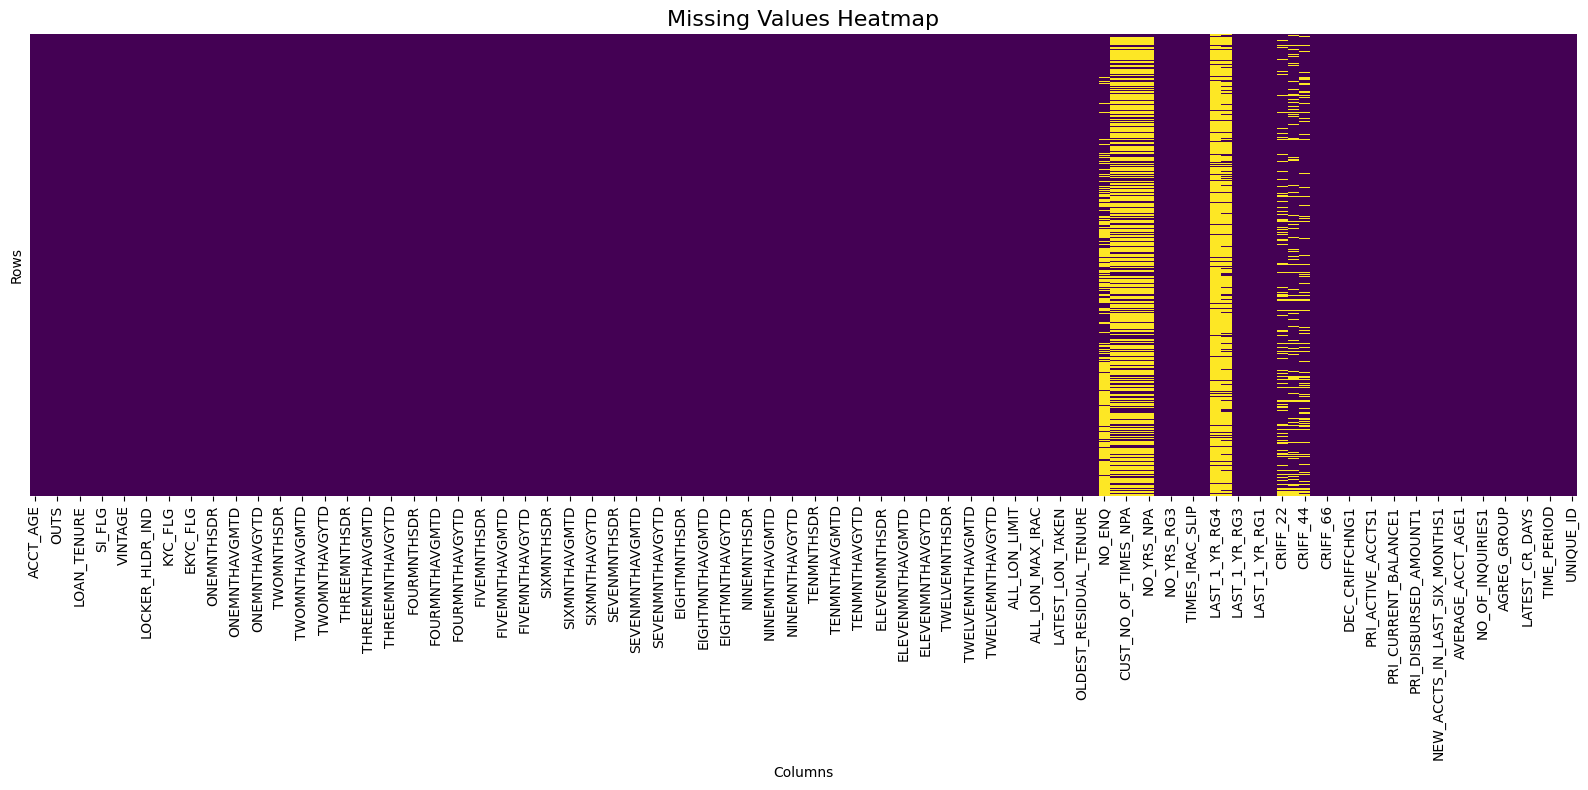

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the figure size
plt.figure(figsize=(16, 8))

# Plot the heatmap
sns.heatmap(df.isnull(), 
            cbar=False, 
            cmap='viridis', 
            yticklabels=False)

plt.title('Missing Values Heatmap', fontsize=16)
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.tight_layout()
plt.show()

In [8]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
import torch
import torch.nn as nn
import torch.optim as optim

# ==== Autoencoder Definition ====
class Autoencoder(nn.Module):
    def __init__(self, input_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, input_dim // 2),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(input_dim // 2, input_dim)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

def train_autoencoder(X_np, num_epochs=100, lr=0.01):
    X_tensor = torch.FloatTensor(X_np)
    model = Autoencoder(X_np.shape[1])
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        output = model(X_tensor)
        loss = criterion(output, X_tensor)
        loss.backward()
        optimizer.step()
    return model

# ==== CATEGORY 3 Imputation ====
def impute_category3(train):
    train = train.copy()
    scaler_11 = StandardScaler()

    # 1️⃣ Impute CRIFF_22 from CRIFF_11 using Autoencoder
    if 'CRIFF_11' in train.columns and 'CRIFF_22' in train.columns:
        ae_train = train[['CRIFF_11', 'CRIFF_22']].dropna()
        X_11 = scaler_11.fit_transform(ae_train[['CRIFF_11']].values)

        autoencoder = train_autoencoder(X_11, num_epochs=200)

        mask = train['CRIFF_22'].isnull() & train['CRIFF_11'].notnull()
        X_missing = scaler_11.transform(train.loc[mask, ['CRIFF_11']].values)
        X_tensor = torch.FloatTensor(X_missing)
        pred_22 = autoencoder(X_tensor).detach().numpy()

        train.loc[mask, 'CRIFF_22'] = pred_22.flatten()

    # 2️⃣ Impute CRIFF_33 from CRIFF_11 + CRIFF_22 using MLP
    if all(col in train.columns for col in ['CRIFF_11', 'CRIFF_22', 'CRIFF_33']):
        mlp_train = train[['CRIFF_11', 'CRIFF_22', 'CRIFF_33']].dropna()
        X = mlp_train[['CRIFF_11', 'CRIFF_22']]
        y = mlp_train['CRIFF_33']

        mlp = MLPRegressor(hidden_layer_sizes=(32, 16), max_iter=300, random_state=42)
        mlp.fit(X, y)

        mask = train['CRIFF_33'].isnull() & train['CRIFF_11'].notnull() & train['CRIFF_22'].notnull()
        X_missing = train.loc[mask, ['CRIFF_11', 'CRIFF_22']]
        train.loc[mask, 'CRIFF_33'] = mlp.predict(X_missing)

    # 3️⃣ Impute CRIFF_44 from CRIFF_55 + CRIFF_66 using MLP
    if all(col in train.columns for col in ['CRIFF_55', 'CRIFF_66', 'CRIFF_44']):
        mlp_train = train[['CRIFF_55', 'CRIFF_66', 'CRIFF_44']].dropna()
        X = mlp_train[['CRIFF_55', 'CRIFF_66']]
        y = mlp_train['CRIFF_44']

        mlp = MLPRegressor(hidden_layer_sizes=(32, 16), max_iter=300, random_state=42)
        mlp.fit(X, y)

        mask = train['CRIFF_44'].isnull() & train['CRIFF_55'].notnull() & train['CRIFF_66'].notnull()
        X_missing = train.loc[mask, ['CRIFF_55', 'CRIFF_66']]
        train.loc[mask, 'CRIFF_44'] = mlp.predict(X_missing)

    return train

In [9]:
df = impute_category3(df)

/usr/local/lib/python3.11/dist-packages/torch/nn/init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


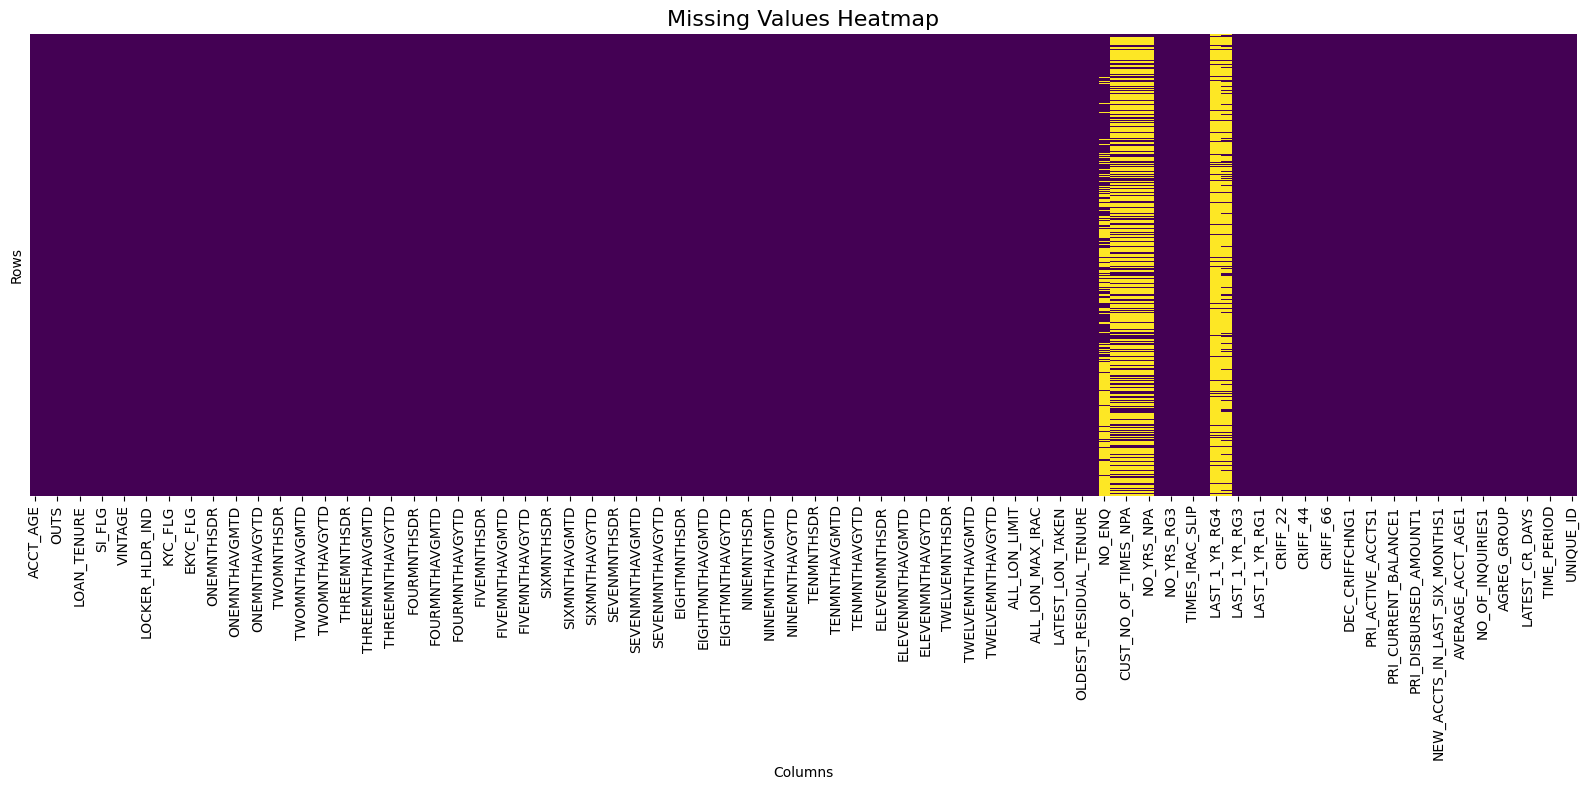

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the figure size
plt.figure(figsize=(16, 8))

# Plot the heatmap
sns.heatmap(df.isnull(), 
            cbar=False, 
            cmap='viridis', 
            yticklabels=False)

plt.title('Missing Values Heatmap', fontsize=16)
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.tight_layout()
plt.show()

In [11]:
df.to_csv('/kaggle/working/imputed.csv')

In [12]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tqdm import tqdm

#%% CONFIGURATION
# Define the columns that contain missing values
columns_to_impute = [
    'LAST_1_YR_RG4', 'LAST_3_YR_RG4', 'FIRST_NPA_TENURE',
    'NO_YRS_NPA', 'CUST_NO_OF_TIMES_NPA', 'LATEST_NPA_TENURE', 'NO_ENQ'
]
# The user explicitly requested not to use the target column, so classifier is disabled.
use_classifier = False 

# Hyperparameters
alpha = 10            # Weight for reconstruction loss in Generator
mb_size = 32          # Mini-batch size
p_hint = 0.9          # Probability of revealing the true mask M in the hint matrix K
epochs = 3000         # Number of training epochs

# Assuming 'df' DataFrame is already loaded and available in the environment.
# Example df structure (replace with your actual data loading):
# df = pd.DataFrame({
#     'LAST_1_YR_RG4': [10, 20, np.nan, 40, 50, 60, np.nan, 80],
#     'LAST_3_YR_RG4': [100, np.nan, 300, 400, 500, np.nan, 700, 800],
#     'FIRST_NPA_TENURE': [1, 2, 3, np.nan, 5, 6, 7, 8],
#     'NO_YRS_NPA': [0, 1, 0, 1, 0, 1, 0, 1],
#     'CUST_NO_OF_TIMES_NPA': [1, 2, 1, 3, 2, 1, 3, 2],
#     'LATEST_NPA_TENURE': [10, 20, 30, 40, np.nan, 60, 70, 80],
#     'NO_ENQ': [5, 10, 15, 20, 25, 30, 35, np.nan],
#     'TARGET': ['A', 'B', 'A', 'B', 'A', np.nan, 'B', 'A'] # This column will not be used by the model.
# })


#%% PREPROCESSING - ROBUST VERSION
print("🔧 Preprocessing data...")

# Extract data
data = df[columns_to_impute].copy()

print(f"📊 Data shape: {data.shape}")
print(f"📊 Missing values per column:")
for col in columns_to_impute:
    missing = data[col].isna().sum()
    total = len(data[col])
    print(f"   {col}: {missing}/{total} ({missing/total*100:.1f}%)")

# Create original mask of observed values for all data
M_original = (~data.isna()).astype(float).values

# Fill NaN with column means instead of zeros (more robust for scaling)
data_filled = data.copy()
for col in columns_to_impute:
    if data_filled[col].isna().all():
        # If all values are NaN, fill with 0
        data_filled[col] = 0
    else:
        # Fill with column mean
        mean_val = data_filled[col].mean()
        data_filled[col] = data_filled[col].fillna(mean_val)

# Check for any remaining NaN or infinite values
data_array = data_filled.values
if np.any(np.isnan(data_array)) or np.any(np.isinf(data_array)):
    print("⚠  Warning: NaN or infinite values found in data_filled - fixing...")
    # Replace any remaining NaN/inf with 0
    data_array = np.nan_to_num(data_array, nan=0.0, posinf=1e6, neginf=-1e6)

# Robust normalization to a (0.01, 0.99) range
scaler = MinMaxScaler(feature_range=(0.01, 0.99))
X_scaled = scaler.fit_transform(data_array)

# Ensure no NaN in scaled data
if np.any(np.isnan(X_scaled)):
    print("⚠  Warning: NaN values in scaled data - fixing...")
    X_scaled = np.nan_to_num(X_scaled, nan=0.5)

print(f"📊 Scaled data range: [{X_scaled.min():.3f}, {X_scaled.max():.3f}]")

# Dataset parameters
All_No = X_scaled.shape[0]

# Split all data into train/test for GAN
X_train, X_test, M_train, M_test = train_test_split(
    X_scaled.astype(np.float32), M_original.astype(np.float32), 
    test_size=0.2, random_state=42
)

Train_No = X_train.shape[0]
Test_No = X_test.shape[0]
Dim = X_scaled.shape[1]

print(f"📊 Training setup:")
print(f"   Total samples: {All_No}")
print(f"   Training samples: {Train_No}")
print(f"   Features: {Dim}")
print(f"   Using classifier: {use_classifier}") # This will be False

#%% TensorFlow Setup
tf.reset_default_graph()

# Placeholders
X = tf.placeholder(tf.float32, shape=[None, Dim], name='X') # Original observed data
M = tf.placeholder(tf.float32, shape=[None, Dim], name='M') # Mask matrix
H = tf.placeholder(tf.float32, shape=[None, Dim], name='H') # Hint matrix
New_X = tf.placeholder(tf.float32, shape=[None, Dim], name='New_X') # Input to Generator (observed + noise for missing)

#%% Xavier Initialization
def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = np.sqrt(2.0 / (in_dim + size[1]))
    return tf.Variable(tf.truncated_normal(shape=size, stddev=xavier_stddev))

#%% Model Components - TensorFlow v1 Compatible
H_Dim1 = Dim # Hidden layer 1 dimension
H_Dim2 = Dim # Hidden layer 2 dimension

# Generator weights
G_W1 = xavier_init([Dim * 2, H_Dim1])
G_b1 = tf.Variable(tf.zeros([H_Dim1]))
G_W2 = xavier_init([H_Dim1, H_Dim2])
G_b2 = tf.Variable(tf.zeros([H_Dim2]))
G_W3 = xavier_init([H_Dim2, Dim])
G_b3 = tf.Variable(tf.zeros([Dim]))
theta_G = [G_W1, G_W2, G_W3, G_b1, G_b2, G_b3]

# Discriminator weights
D_W1 = xavier_init([Dim * 2, H_Dim1])
D_b1 = tf.Variable(tf.zeros([H_Dim1]))
D_W2 = xavier_init([H_Dim1, H_Dim2])
D_b2 = tf.Variable(tf.zeros([H_Dim2]))
D_W3 = xavier_init([H_Dim2, Dim])
D_b3 = tf.Variable(tf.zeros([Dim]))
theta_D = [D_W1, D_W2, D_W3, D_b1, D_b2, D_b3]

def generator(new_x, m):
    """Generator network"""
    inputs = tf.concat([new_x, m], axis=1) # new_x: observed + noise for missing, m: mask
    
    # Layer 1
    h1 = tf.nn.relu(tf.matmul(inputs, G_W1) + G_b1)
    h1 = tf.nn.dropout(h1, keep_prob=0.8) # Dropout for regularization
    
    # Layer 2
    h2 = tf.nn.relu(tf.matmul(h1, G_W2) + G_b2)
    h2 = tf.nn.dropout(h2, keep_prob=0.8)
    
    # Output layer with clipping to keep values within scaled range
    output = tf.nn.sigmoid(tf.matmul(h2, G_W3) + G_b3)
    output = tf.clip_by_value(output, 0.01, 0.99) # Clip output to stay within feature_range
    
    return output

def discriminator(x_hat, h):
    """Discriminator network"""
    inputs = tf.concat([x_hat, h], axis=1) # x_hat: completed data, h: hint matrix
    
    # Layer 1
    h1 = tf.nn.relu(tf.matmul(inputs, D_W1) + D_b1)
    h1 = tf.nn.dropout(h1, keep_prob=0.7)
    
    # Layer 2
    h2 = tf.nn.relu(tf.matmul(h1, D_W2) + D_b2)
    h2 = tf.nn.dropout(h2, keep_prob=0.7)
    
    # Output layer (probability of being real/correct mask)
    output = tf.nn.sigmoid(tf.matmul(h2, D_W3) + D_b3)
    
    return output

#%% Model Assembly
G_sample = generator(New_X, M) # Generator output (imputed missing values)
# X_hat combines original observed values (M * X) with imputed missing values (G_sample * (1 - M))
X_hat = M * X + (1 - M) * G_sample 
D_prob = discriminator(X_hat, H) # Discriminator's probability for each element

#%% Loss Functions with Stability Improvements
# Discriminator loss: Tries to make D_prob match the mask M
D_loss = -tf.reduce_mean(M * tf.log(D_prob + 1e-8) + (1 - M) * tf.log(1. - D_prob + 1e-8))

# Generator adversarial loss: Tries to fool the discriminator for missing values
G_loss_adv = -tf.reduce_mean((1 - M) * tf.log(D_prob + 1e-8))

# Generator reconstruction loss (Mean Absolute Error as per paper)
# Calculated only for observed values
MSE_train_loss = tf.reduce_mean(tf.abs(M * X - M * G_sample)) / (tf.reduce_mean(M) + 1e-8)

# Combined generator loss (no classifier loss in this unsupervised version)
G_loss = G_loss_adv + alpha * MSE_train_loss

# Add L2 regularization to prevent overfitting
l2_reg = 0.001
G_loss += l2_reg * sum([tf.nn.l2_loss(v) for v in theta_G])
D_loss += l2_reg * sum([tf.nn.l2_loss(v) for v in theta_D])

#%% Optimizers
learning_rate = 0.0001 # Set a specific learning rate

D_solver = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(D_loss, var_list=theta_D)
G_solver = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(G_loss, var_list=theta_G)

#%% Helper Functions
def sample_Z(m, n): 
    # Use a slightly wider uniform range for noise, but still small
    return np.random.uniform(0.0, 0.1, size=[m, n]).astype(np.float32)

def sample_M(m, n, p): 
    # Generates a binary mask with 1s having probability 'p'
    return (np.random.uniform(0., 1., size=[m, n]) < p).astype(np.float32)

def sample_idx(m, n): 
    # Samples 'n' unique indices from 'm' total indices
    return np.random.permutation(m)[:n]

#%% Training Session
config = tf.ConfigProto()
config.gpu_options.allow_growth = True # Dynamically allocate GPU memory
config.allow_soft_placement = True # Allow TensorFlow to fall back to CPU
sess = tf.Session(config=config)
sess.run(tf.global_variables_initializer())

print("\n🔧 Training SEGAN...")

# Training metrics for early stopping
best_mse = float('inf')
patience = 1000 # Number of iterations to wait for improvement before stopping
no_improve = 0

try:
    for it in range(epochs):
        # Sample batch
        if Train_No < mb_size: # Handle cases where dataset is smaller than batch size
            idx = np.arange(Train_No)
        else:
            idx = sample_idx(Train_No, mb_size)
        
        X_mb = X_train[idx] # Original data for batch
        M_mb = M_train[idx] # Mask for batch
        
        batch_size_actual = len(idx)
        Z_mb = sample_Z(batch_size_actual, Dim) # Noise for generator input
        
        # New_X_mb is the input to the generator: observed values from X_mb, noise for missing values
        New_X_mb = M_mb * X_mb + (1 - M_mb) * Z_mb 

        # CORRECTED HINT MATRIX (H_mb or R) generation based on paper: H = K * M + 0.5 * (1 - K)
        # K_mb will have 1s with probability p_hint (probability of revealing true mask)
        K_mb = sample_M(batch_size_actual, Dim, p_hint) 
        H_mb = K_mb * M_mb + 0.5 * (1 - K_mb)
        
        # Check for invalid inputs
        if np.any(np.isnan(New_X_mb)) or np.any(np.isnan(M_mb)) or np.any(np.isnan(H_mb)):
            print(f"⚠  Invalid inputs at iteration {it} - skipping batch.")
            continue
        
        feed_dict = {X: X_mb, M: M_mb, New_X: New_X_mb, H: H_mb} 
        
        # Training step
        try:
            # 1. Train discriminator
            _, D_curr = sess.run([D_solver, D_loss], feed_dict=feed_dict)
            
            # 2. Train generator
            _, G_curr, MSE_curr = sess.run([G_solver, G_loss, MSE_train_loss], feed_dict=feed_dict)
            
        except Exception as e:
            print(f"⚠  Training error at iteration {it}: {e} - skipping batch.")
            continue
        
        # Check for NaN losses
        if np.isnan(G_curr) or np.isnan(D_curr) or np.isnan(MSE_curr):
            print(f"⚠  NaN loss at iteration {it} - stopping training.")
            break
        
        # Early stopping logic
        if MSE_curr < best_mse:
            best_mse = MSE_curr
            no_improve = 0
        else:
            no_improve += 1
        
        if no_improve > patience:
            print(f"\n⏹  Early stopping at iteration {it} due to no improvement in MSE.")
            break
        
        # Progress reporting 
        if it % 200 == 0 or it == epochs - 1:
            print(f"Iter {it:4d}: G={G_curr:.4f}, D={D_curr:.4f}, MSE={MSE_curr:.4f}")
    
    print("\n✅ Training completed successfully!")
    
except Exception as e:
    print(f"❌ Training failed: {e}")
    print("Proceeding with current model state for imputation...")

#%% Imputation with Robust Error Handling
print("\n🔄 Performing imputation...")

def safe_impute_batch(x_batch, m_batch, session):
    """Safely impute a batch with error handling"""
    try:
        batch_size_actual = x_batch.shape[0]
        z_batch = sample_Z(batch_size_actual, Dim)
        # For evaluation/imputation, K=1 is common to fully reveal the mask M (H = M)
        K_batch = np.ones((batch_size_actual, Dim), dtype=np.float32) 
        h_batch = K_batch * m_batch + 0.5 * (1 - K_batch) 
        
        # New_X_batch for imputation: observed from x_batch, noise for missing
        new_x_batch = m_batch * x_batch + (1 - m_batch) * z_batch
        
        # Check inputs for NaNs/Infs
        if np.any(np.isnan(new_x_batch)) or np.any(np.isnan(m_batch)) or np.any(np.isnan(h_batch)):
            print("⚠  Invalid inputs detected in imputation batch. Returning original values.")
            return x_batch # Return original if inputs are invalid
        
        imputed = session.run(G_sample, feed_dict={
            New_X: new_x_batch,
            M: m_batch,
            X: x_batch, # X is needed for X_hat calculation within generator path for D
            H: h_batch
        })
        
        # Check output for NaNs/Infs
        if np.any(np.isnan(imputed)) or np.any(np.isinf(imputed)):
            print("⚠  NaN/Inf values in imputed output. Returning original values.")
            return x_batch # Return original if output is invalid
        
        # Combine original observed values with imputed missing values
        return m_batch * x_batch + (1 - m_batch) * imputed
        
    except Exception as e:
        print(f"⚠  Batch imputation error: {e}. Returning original values for this batch.")
        return x_batch

# Test generator on a small subset first
test_size_imputation = min(10, All_No)
test_x_imputation = X_scaled[:test_size_imputation].astype(np.float32)
test_m_imputation = M_original[:test_size_imputation].astype(np.float32)
test_result_imputation = safe_impute_batch(test_x_imputation, test_m_imputation, sess)

# Decide whether to proceed with GAN imputation or fallback
# Fallback if generator test returns original (unimputed) data AND there were missing values
if np.array_equal(test_result_imputation, test_x_imputation) and test_m_imputation.sum() != len(test_x_imputation) * Dim:
    print("❌ Generator test failed or returned unimputed data - using fallback imputation.")
    
    # Fallback imputation using column means on the original df
    df_imputed = df.copy()
    for col in columns_to_impute:
        if df_imputed[col].isna().any():
            mean_val = df[col].mean() # Use original df for mean calculation
            if pd.isna(mean_val): # If column is all NaNs, mean is NaN, fill with 0
                mean_val = 0
            df_imputed[col] = df_imputed[col].fillna(mean_val)
            print(f"   {col}: Filled with mean {mean_val:.4f}")
    
else:
    print("✅ Generator test passed - proceeding with GAN imputation.")
    
    # Batch imputation for the entire dataset
    batch_size_impute = 500
    imputed_all_scaled = np.zeros_like(X_scaled)
    
    for start_idx in tqdm(range(0, All_No, batch_size_impute), desc="Imputing"):
        end_idx = min(start_idx + batch_size_impute, All_No)
        
        x_batch = X_scaled[start_idx:end_idx].astype(np.float32)
        m_batch = M_original[start_idx:end_idx].astype(np.float32)
        
        imputed_batch_scaled = safe_impute_batch(x_batch, m_batch, sess)
        imputed_all_scaled[start_idx:end_idx] = imputed_batch_scaled
    
    # Inverse transform to original scale and integrate back into DataFrame
    imputed_final = scaler.inverse_transform(imputed_all_scaled)
    
    df_imputed = df.copy()
    for i, col in enumerate(columns_to_impute):
        original_col_data = df[col].values.copy()
        nan_mask_col = np.isnan(original_col_data)
        
        if nan_mask_col.sum() > 0:
            imputed_values_for_col = imputed_final[nan_mask_col, i]
            
            # Final safety check for any remaining NaNs after inverse transform
            if np.any(np.isnan(imputed_values_for_col)):
                mean_val_original = df[col].mean()
                if pd.isna(mean_val_original):
                    mean_val_original = 0
                imputed_values_for_col = np.where(np.isnan(imputed_values_for_col), mean_val_original, imputed_values_for_col)
            
            original_col_data[nan_mask_col] = imputed_values_for_col
            df_imputed[col] = original_col_data

# Close TensorFlow session
sess.close()

#%% Results
print("\n📈 Final Imputation Results:")
total_before = 0
total_after = 0

for col in columns_to_impute:
    before = df[col].isna().sum()
    after = df_imputed[col].isna().sum()
    total_before += before
    total_after += after
    print(f"   {col}: {before} NaN values (Before) → {after} NaN values (After)")

print(f"\n🎯 Overall NaN values: {total_before} (Before) → {total_after} (After)")

if total_after == 0:
    print("🎉 SUCCESS: All missing values imputed!")
else:
    print("⚠  Some NaN values still remain. Consider increasing epochs or adjusting hyperparameters.")

print("\n✅ Imputation complete. Updated DataFrame is available in df_imputed.")

2025-07-27 12:43:55.173591: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753620235.553363      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753620235.660010      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


🔧 Preprocessing data...
📊 Data shape: (325833, 7)
📊 Missing values per column:
   LAST_1_YR_RG4: 301502/325833 (92.5%)
   LAST_3_YR_RG4: 265995/325833 (81.6%)
   FIRST_NPA_TENURE: 214164/325833 (65.7%)
   NO_YRS_NPA: 214164/325833 (65.7%)
   CUST_NO_OF_TIMES_NPA: 214164/325833 (65.7%)
   LATEST_NPA_TENURE: 214164/325833 (65.7%)
   NO_ENQ: 166558/325833 (51.1%)
📊 Scaled data range: [0.010, 0.990]
📊 Training setup:
   Total samples: 325833
   Training samples: 260666
   Features: 7
   Using classifier: False


I0000 00:00:1753620253.593477      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1753620253.594345      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5
I0000 00:00:1753620253.607315      19 mlir_graph_optimization_pass.cc:401] MLIR V1 optimization pass is not enabled



🔧 Training SEGAN...
Iter    0: G=4.4419, D=0.6847, MSE=0.3897
Iter  200: G=4.4213, D=0.6471, MSE=0.3774
Iter  400: G=4.1040, D=0.6507, MSE=0.3458
Iter  600: G=3.9410, D=0.6558, MSE=0.3300
Iter  800: G=3.7669, D=0.6334, MSE=0.3112
Iter 1000: G=3.0100, D=0.6074, MSE=0.2415
Iter 1200: G=2.9448, D=0.5445, MSE=0.2135
Iter 1400: G=2.6080, D=0.5576, MSE=0.1819
Iter 1600: G=2.0870, D=0.5572, MSE=0.1357
Iter 1800: G=2.4345, D=0.4547, MSE=0.1450
Iter 2000: G=1.8267, D=0.4679, MSE=0.0780
Iter 2200: G=1.9607, D=0.5254, MSE=0.1084
Iter 2400: G=1.7300, D=0.4207, MSE=0.0711
Iter 2600: G=1.9099, D=0.3518, MSE=0.0551
Iter 2800: G=1.9642, D=0.4355, MSE=0.0800
Iter 2999: G=1.9386, D=0.4016, MSE=0.0773

✅ Training completed successfully!

🔄 Performing imputation...
✅ Generator test passed - proceeding with GAN imputation.


Imputing: 100%|██████████| 652/652 [00:00<00:00, 735.30it/s]



📈 Final Imputation Results:
   LAST_1_YR_RG4: 301502 NaN values (Before) → 0 NaN values (After)
   LAST_3_YR_RG4: 265995 NaN values (Before) → 0 NaN values (After)
   FIRST_NPA_TENURE: 214164 NaN values (Before) → 0 NaN values (After)
   NO_YRS_NPA: 214164 NaN values (Before) → 0 NaN values (After)
   CUST_NO_OF_TIMES_NPA: 214164 NaN values (Before) → 0 NaN values (After)
   LATEST_NPA_TENURE: 214164 NaN values (Before) → 0 NaN values (After)
   NO_ENQ: 166558 NaN values (Before) → 0 NaN values (After)

🎯 Overall NaN values: 1590711 (Before) → 0 (After)
🎉 SUCCESS: All missing values imputed!

✅ Imputation complete. Updated DataFrame is available in df_imputed.


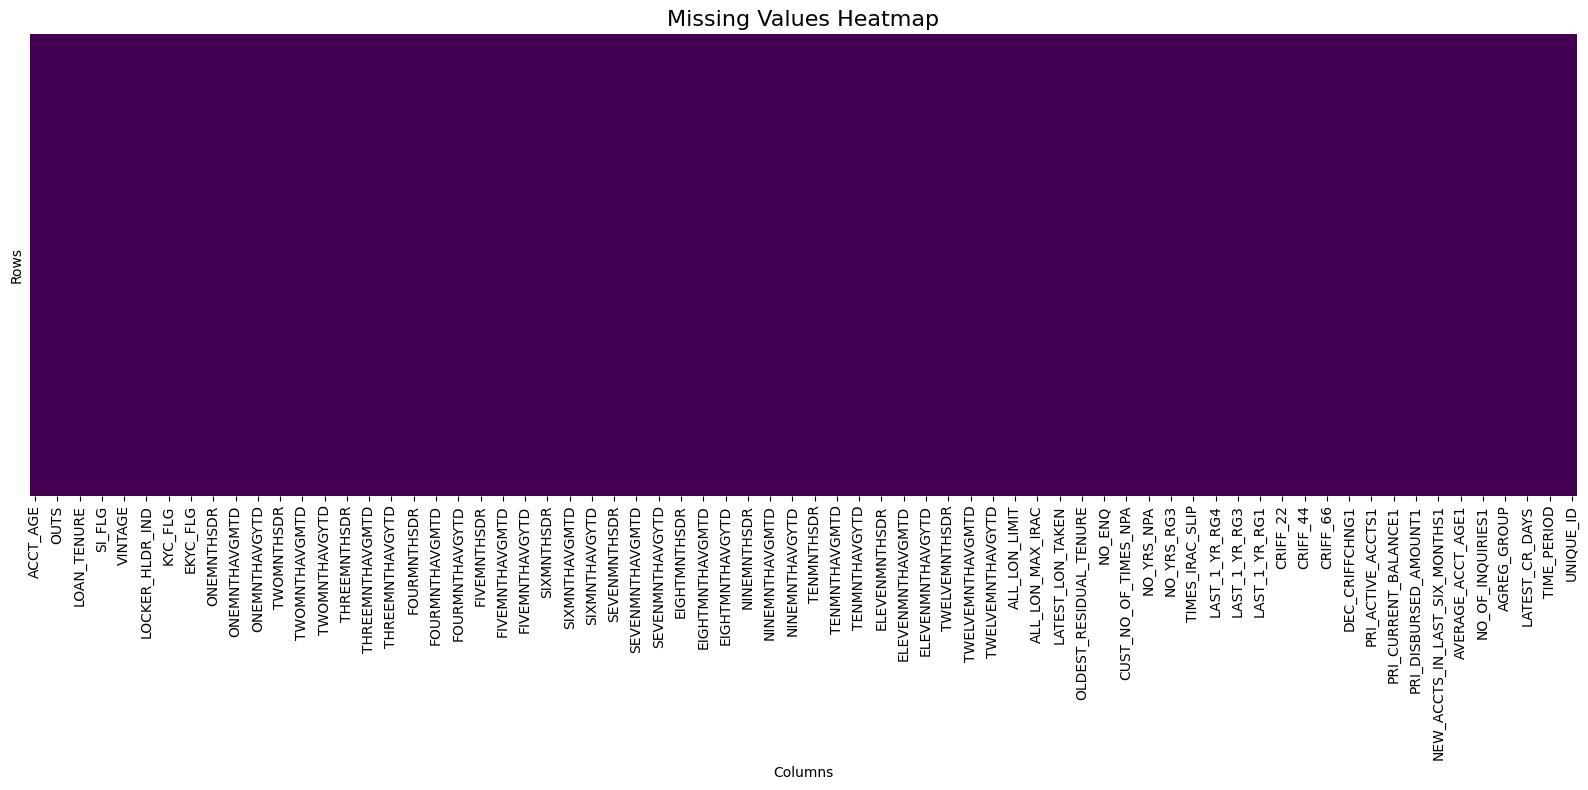

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the figure size
plt.figure(figsize=(16, 8))

# Plot the heatmap
sns.heatmap(df_imputed.isnull(), 
            cbar=False, 
            cmap='viridis', 
            yticklabels=False)

plt.title('Missing Values Heatmap', fontsize=16)
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.tight_layout()
plt.show()

In [14]:
df_imputed.to_csv('/kaggle/working/cleaned.csv')

In [15]:
df1 = pd.read_csv('/kaggle/input/sbihack/HACKATHON_TRAINING_DATA.CSV')

In [16]:
from scipy.special import rel_entr  # More numerically stable than manual log
import numpy as np

def compute_kl_for_column(col_original, col_imputed, epsilon=1e-10):
    """
    Computes KL divergence between value distributions of original and imputed column
    """
    p_counts = col_original.value_counts(normalize=True)
    q_counts = col_imputed.value_counts(normalize=True)

    # Align index
    all_values = set(p_counts.index).union(set(q_counts.index))
    p = np.array([p_counts.get(val, 0) for val in all_values])
    q = np.array([q_counts.get(val, 0) for val in all_values])

    # Smooth to avoid log(0)
    p = np.clip(p, epsilon, 1)
    q = np.clip(q, epsilon, 1)
    p /= p.sum()
    q /= q.sum()

    kl = np.sum(rel_entr(p, q))  # rel_entr = p * log(p/q)
    return kl
def compute_kl_numerical_hist(original, imputed, bins=30, epsilon=1e-10):
    # Histogram (normalize=True => probabilities)
    p_hist, bin_edges = np.histogram(original.dropna(), bins=bins, density=True)
    q_hist, _ = np.histogram(imputed.dropna(), bins=bin_edges, density=True)

    # Normalize to sum to 1 (prob distributions)
    p = np.clip(p_hist / p_hist.sum(), epsilon, 1)
    q = np.clip(q_hist / q_hist.sum(), epsilon, 1)

    p /= p.sum()
    q /= q.sum()

    return np.sum(rel_entr(p, q))


In [17]:
categorical_cols = df1.select_dtypes(include='object').columns

for col in categorical_cols:
    kl = compute_kl_for_column(df1[col], df_imputed[col])
    print(f"KL divergence for column '{col}': {kl:.4f}")


KL divergence for column 'SI_FLG': 0.0000
KL divergence for column 'LOCKER_HLDR_IND': 0.0000
KL divergence for column 'UID_FLG': 0.0000
KL divergence for column 'KYC_FLG': 0.0004
KL divergence for column 'INB_FLG': 0.0000
KL divergence for column 'EKYC_FLG': 0.0000
KL divergence for column 'AVERAGE_ACCT_AGE1': 0.0001
KL divergence for column 'CREDIT_HISTORY_LENGTH1': 0.0002
KL divergence for column 'INCOME_BAND1': 0.0000
KL divergence for column 'AGREG_GROUP': 0.0000
KL divergence for column 'PRODUCT_TYPE': 0.0000
KL divergence for column 'TIME_PERIOD': 0.0000


In [18]:
numerical_cols = df1.select_dtypes(include=[np.number]).columns

for col in numerical_cols:
    kl = compute_kl_numerical_hist(df1[col], df_imputed[col])
    print(f"KL divergence for numerical column '{col}': {kl:.4f}")


KL divergence for numerical column 'ACCT_AGE': 0.0000
KL divergence for numerical column 'LIMIT': 0.0000
KL divergence for numerical column 'OUTS': 0.0000
KL divergence for numerical column 'ACCT_RESIDUAL_TENURE': 0.0001
KL divergence for numerical column 'LOAN_TENURE': 0.0000
KL divergence for numerical column 'INSTALAMT': 0.0000
KL divergence for numerical column 'AGE': 0.0001
KL divergence for numerical column 'VINTAGE': 0.0000
KL divergence for numerical column 'KYC_SCR': 0.0000
KL divergence for numerical column 'ONEMNTHCR': 0.0000
KL divergence for numerical column 'ONEMNTHSDR': 0.0000
KL divergence for numerical column 'ONEMNTHOUTSTANGBAL': 0.0000
KL divergence for numerical column 'ONEMNTHAVGMTD': 0.0000
KL divergence for numerical column 'ONEMNTHAVGQTD': 0.0000
KL divergence for numerical column 'ONEMNTHAVGYTD': 0.0024
KL divergence for numerical column 'TWOMNTHSCR': 0.0000
KL divergence for numerical column 'TWOMNTHSDR': 0.0000
KL divergence for numerical column 'TWOMNTHOUTST

In [19]:
df_imputed.columns

Index(['ACCT_AGE', 'LIMIT', 'OUTS', 'ACCT_RESIDUAL_TENURE', 'LOAN_TENURE',
       'INSTALAMT', 'SI_FLG', 'AGE', 'VINTAGE', 'KYC_SCR',
       ...
       'CREDIT_HISTORY_LENGTH1', 'NO_OF_INQUIRIES1', 'INCOME_BAND1',
       'AGREG_GROUP', 'PRODUCT_TYPE', 'LATEST_CR_DAYS', 'LATEST_DR_DAYS',
       'TIME_PERIOD', 'TARGET', 'UNIQUE_ID'],
      dtype='object', length=139)

In [20]:
df_imputed.rename(columns={'ONEMNTHCR': 'ONEMNTHSCR'}, inplace=True)


In [21]:
months = [
    'ONEMNTH', 'TWOMNTH', 'THREEMNTH', 'FOURMNTH', 'FIVEMNTH', 'SIXMNTH', 'SEVENMNTH',
    'EIGHTMNTH', 'NINEMNTH', 'TENMNTH', 'ELEVENMNTH', 'TWELVEMNTH'
]
months_available = {
    'CR': [f'{m}SCR' for m in months],
    'DR': [f'{m}SDR' for m in months],
    'BAL': [f'{m}OUTSTANGBAL' for m in months],
    'QTD': [f'{m}AVGQTD' for m in months],
    'YTD': [f'{m}AVGYTD' for m in months],
}

In [22]:
import numpy as np

# Function definitions for the features

def compute_net_flow_trend(df, cr_cols, dr_cols):
    net_flows = df[cr_cols].values - df[dr_cols].values
    months = np.arange(1, 13)
    # Linear regression slope for each row
    slopes = np.apply_along_axis(lambda y: np.polyfit(months, y, 1)[0], axis=1, arr=net_flows)
    return slopes

def compute_ema(df, cols, alpha=0.2):
    # Simple EMA with smoothing factor alpha
    def ema_row(x):
        ema = [x[0]]
        for val in x[1:]:
            ema.append(alpha * val + (1 - alpha) * ema[-1])
        return ema[-1]  # Return last EMA value
    return df[cols].apply(ema_row, axis=1)

def compute_net_flow_ema(df, cr_cols, dr_cols, alpha=0.2):
    net_flows = df[cr_cols].values - df[dr_cols].values
    def ema_row(x):
        ema = [x[0]]
        for val in x[1:]:
            ema.append(alpha * val + (1 - alpha) * ema[-1])
        return ema[-1]
    return np.apply_along_axis(ema_row, 1, net_flows)

def compute_std(df, cols):
    return df[cols].std(axis=1)

def compute_utilization_ratio(df, epsilon=1e-6):
    return df["ALL_LON_OUTS"] / (df["ALL_LON_LIMIT"].replace(0, epsilon))

def compute_rdr(df, epsilon=1):
    return df["TIMES_IRAC_SLIP"] / (df["TIMES_IRAC_UPR"] + epsilon)

# Column mappings
cr_cols = months_available["CR"]
dr_cols = months_available["DR"]
bal_cols = months_available["BAL"]
qtd_cols = months_available["QTD"]
ytd_cols = months_available["YTD"]

# Function to apply all feature computations on a dataframe
def create_features(df):
    df_out = pd.DataFrame(index=df.index)

    df_out["NET_FLOW_TREND"] = compute_net_flow_trend(df, cr_cols, dr_cols)
    df_out["AVG.CREDIT_EMA"] = compute_ema(df, cr_cols)
    df_out["AVG.DEBIT_EMA"] = compute_ema(df, dr_cols)
    df_out["AVG.NET_FLOW_EMA"] = compute_net_flow_ema(df, cr_cols, dr_cols)
    df_out["BALANCE_VOLATILITY"] = compute_std(df, bal_cols)
    df_out["QTD_VOLATILITY"] = compute_std(df, qtd_cols)
    df_out["YTD_VOLATILITY"] = compute_std(df, ytd_cols)
    df_out["UTILIZATION_RATIO"] = compute_utilization_ratio(df)
    df_out["RISK_DETERIORATION_RATE"] = compute_rdr(df)

    return df_out

# Ready for use with a DataFrame

df_feat = create_features(df_imputed)
df_final = df_imputed.drop(columns=months_available["CR"] + months_available["DR"] + months_available["QTD"] + months_available["YTD"])
# Merge new features into the original dataframe
df_final = pd.concat([df_imputed, df_feat], axis=1)

/tmp/ipykernel_19/1687191930.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ema = [x[0]]
/tmp/ipykernel_19/1687191930.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ema = [x[0]]


In [23]:
df_final

,ACCT_AGE,LIMIT,OUTS,ACCT_RESIDUAL_TENURE,LOAN_TENURE,INSTALAMT,SI_FLG,AGE,VINTAGE,KYC_SCR,...,UNIQUE_ID,NET_FLOW_TREND,AVG.CREDIT_EMA,AVG.DEBIT_EMA,AVG.NET_FLOW_EMA,BALANCE_VOLATILITY,QTD_VOLATILITY,YTD_VOLATILITY,UTILIZATION_RATIO,RISK_DETERIORATION_RATE
0,1.613,1005500.0,494161.89,0.890,914,38513.0,Y,57.663,18.601,110.0,...,2032,23349.908509,89768.594899,-93513.305644,183281.900543,6.110587e+04,2.966566e+04,4.101103e+04,0.292297,0.818182
1,1.783,1005500.0,428072.24,0.720,914,38513.0,Y,57.833,18.771,110.0,...,2033,-14096.729180,74032.603730,-93957.273897,167989.877627,4.868523e+04,4.840899e+04,6.093601e+04,0.237093,0.772727
2,1.698,1005500.0,461364.10,0.805,914,38513.0,Y,57.748,18.686,110.0,...,2034,18256.863445,93452.834738,-110375.388495,203828.223233,5.348634e+04,3.381404e+04,4.425004e+04,0.255533,0.818182
3,9.127,1005500.0,1204287.25,17.878,9862,12736.0,Y,52.302,14.039,110.0,...,2035,16.136329,16.194768,-66.788800,82.983568,1.348643e+02,1.748461e+02,1.487280e+02,1.185775,0.708333
4,9.296,1005500.0,1203224.25,17.708,9862,12736.0,Y,52.472,14.209,110.0,...,2036,1.622832,8.251200,0.000000,8.251200,2.886751e-01,5.643346e+01,1.095011e+02,1.184227,0.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
327736,11.837,185161.0,166393.79,4.411,5934,3688.0,Y,61.483,17.399,121.0,...,504220,0.000000,0.000000,0.000000,0.000000,1.484275e-14,1.484275e-14,1.484275e-14,0.358483,0.923077
327737,2.516,735500.0,529552.88,3.486,2192,14310.0,Y,27.482,8.902,110.0,...,504222,3241.583392,20884.043833,-24579.138021,45463.181855,9.769391e+03,2.682895e+03,7.264850e+03,0.742868,0.666667
327738,2.944,705500.0,849950.35,13.059,5844,9770.0,N,25.286,7.062,110.0,...,505863,-180.129685,46.173756,-385.933635,432.107392,4.845820e+03,3.900648e+03,1.730374e+03,1.204749,0.400000
327739,1.021,205500.0,169529.00,1.980,1096,6865.0,Y,34.353,13.261,110.0,...,505869,8204.227972,33264.271362,-34856.968883,68121.240245,1.772564e+03,4.438892e+03,1.077277e+03,0.824959,0.625000


In [24]:
df_final.isna().sum().sum()

0

In [25]:
from sklearn.preprocessing import OneHotEncoder

# Make a copy
df_encoded = df_final.copy()

# Step 1: Encode Y/N as 1/0
yn_cols = df_encoded.select_dtypes(include=['object']).columns
df_encoded[yn_cols] = df_encoded[yn_cols].apply(lambda col: col.replace({'Y': 1, 'N': 0}))

# Step 2: Find remaining non-numeric categorical columns (after Y/N encoding)
non_numeric_cols = df_encoded.select_dtypes(include=['object', 'category']).columns

# Step 3: One-hot encode them (if any)
if len(non_numeric_cols) > 0:
    df_encoded = pd.get_dummies(df_encoded, columns=non_numeric_cols, drop_first=True)


/tmp/ipykernel_19/331717024.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_encoded[yn_cols] = df_encoded[yn_cols].apply(lambda col: col.replace({'Y': 1, 'N': 0}))


In [26]:
df_encoded.isna().sum().sum()

0

In [27]:
df_encoded['AGREG_GROUP_#Total Xpress Credit'].dtype

dtype('bool')

In [28]:
df_encoded.to_csv('/kaggle/working/processed.csv')

In [29]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer
from sklearn.metrics import accuracy_score
import shap
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier

# Split features and target
X = df_encoded.drop(columns=['TARGET'])
y = df_encoded['TARGET']

# Identify numerical columns
num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Apply Box-Cox transformation to numerical columns
# pt = PowerTransformer(method='box-cox', standardize=True)
# X_train_boxcox = X_train.copy()
# X_test_boxcox = X_test.copy()

# # Box-Cox requires all positive values
# for col in num_cols:
#     min_val = min(X_train[col].min(), X_test[col].min())
#     if min_val <= 0:
#         X_train_boxcox[col] = X_train[col] + abs(min_val) + 1e-3
#         X_test_boxcox[col] = X_test[col] + abs(min_val) + 1e-3
#     else:
#         X_train_boxcox[col] = X_train[col]
#         X_test_boxcox[col] = X_test[col]

# X_train_boxcox[num_cols] = pt.fit_transform(X_train_boxcox[num_cols])
# X_test_boxcox[num_cols] = pt.transform(X_test_boxcox[num_cols])


In [30]:
X_train = X_train_boxcox

NameError: name 'X_train_boxcox' is not defined

In [ ]:
X_train.isna().sum().sum()

In [ ]:
X_test = X_test_boxcox

In [ ]:
from sklearn.metrics import classification_report
import shap
import matplotlib.pyplot as plt

# Train XGBoost
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)

# Classification Report
print("🔹 XGBoost Classification Report:\n")
print(classification_report(y_test, xgb_pred))

# SHAP values
xgb_explainer = shap.Explainer(xgb_model, X_train)
xgb_shap_values = xgb_explainer(X_test)

# SHAP summary plot (bar)
shap.summary_plot(xgb_shap_values, X_test, plot_type="bar", show=False)
plt.title("XGBoost - SHAP Summary (Bar)")
plt.show()

# SHAP beeswarm
shap.summary_plot(xgb_shap_values, X_test)


In [ ]:
# Train CatBoost
cat_model = CatBoostClassifier(verbose=0)
cat_model.fit(X_train, y_train)
cat_pred = cat_model.predict(X_test)

# Classification Report
print("🔹 CatBoost Classification Report:\n")
print(classification_report(y_test, cat_pred))

# SHAP values
cat_explainer = shap.Explainer(cat_model.predict, X_train)
cat_shap_values = cat_explainer(X_test)

# SHAP summary plot (bar)
shap.summary_plot(cat_shap_values, X_test, plot_type="bar", show=False)
plt.title("CatBoost - SHAP Summary (Bar)")
plt.show()

# SHAP beeswarm
shap.summary_plot(cat_shap_values, X_test)


In [ ]:
# Train LightGBM
lgb_model = lgb.LGBMClassifier()
lgb_model.fit(X_train, y_train)
lgb_pred = lgb_model.predict(X_test)

# Classification Report
print("🔹 LightGBM Classification Report:\n")
print(classification_report(y_test, lgb_pred))

# SHAP values
lgb_explainer = shap.Explainer(lgb_model, X_train)
lgb_shap_values = lgb_explainer(X_test)

# SHAP summary plot (bar)
shap.summary_plot(lgb_shap_values, X_test, plot_type="bar", show=False)
plt.title("LightGBM - SHAP Summary (Bar)")
plt.show()

# SHAP beeswarm
shap.summary_plot(lgb_shap_values, X_test)
